 ### Задача

 Поиск минимум функции $f(x) = (x-a)^2$, при $M > 0$ и $a > 0$ на интервале $[0, 31]$, где $x$ - целое число


### Кодирование

Используем бинарные строки длиной 5 бит (2⁵ = 32 значения):

|код|значение|
|:-----|:-----:|
|00000|0|
|00001|1|
|00010|2|
|...|...|
|11111|31|

### Функция приспособленности

$\text{fitness}(x) = (31-a)^2 - (x - a)^2$

$\text{fitness}(x) = |31-a| - |x - a|$

$\text{fitness}(x) = (|31-a| - |x - a|)^4$

In [303]:
a = 10
def fitness(x):
  return (np.abs(31 - a) - np.abs(x - a))**4

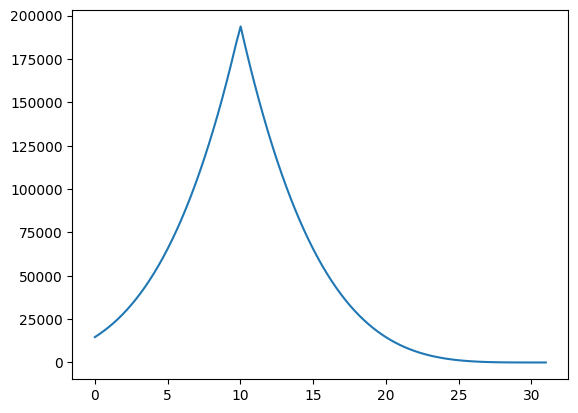

In [305]:
import matplotlib.pyplot as plt
x = np.linspace(0,31, 100)
plt.plot(x, fitness(x))

In [306]:
fitness(x).max()

np.float64(193733.71556104004)

### Начальная популяция

In [307]:
import numpy as np
import pandas as pd
n = 6 # рамер популяции
population = np.random.randint(0, 32, n)
codes = [f'{individual:05b}' for individual in population]
df = pd.DataFrame({'individual': population, 'code': codes, 'fit': fitness(population)})
df

,individual,code,fit
0,15,01111,65536
1,23,10111,4096
2,14,01110,83521
3,11,01011,160000
4,5,00101,65536
5,19,10011,20736


Сумма приспособленностей

In [308]:
sum = df['fit'].sum()
sum, df['fit'].mean()

(np.int64(399425), np.float64(66570.83333333333))

### Оператор селекции (Метод рулетки)

Рассчитаем вероятности выбора для каждой особи

In [309]:
df['probability'] = df['fit'] / sum
df_sorted = df.sort_values('probability')
df_sorted

,individual,code,fit,probability
1,23,10111,4096,0.010255
5,19,10011,20736,0.051915
4,5,00101,65536,0.164076
0,15,01111,65536,0.164076
2,14,01110,83521,0.209103
3,11,01011,160000,0.400576


In [310]:
pr = df_sorted['probability'].cumsum()
pr

,probability
1,0.010255
5,0.062169
4,0.226245
0,0.390321
2,0.599424
3,1.000000


Генерируем $n$ случайных чисел и выбираем родителей

In [313]:
alphas = np.random.uniform(0, 1, n)
alphas

array([0.27063542, 0.19608657, 0.55904978, 0.36908942, 0.12289364,
       0.16905788])

In [314]:
parents = pd.DataFrame({'individual':[],	'code':[],	'fit':[],	'probability':[]})
for alpha in alphas:
  ind = df_sorted.iloc[(pr < alpha).argsort()[:1]]
  parents = pd.concat([parents, ind])
parents

,individual,code,fit,probability
0,15.0,01111,65536.0,0.164076
4,5.0,00101,65536.0,0.164076
2,14.0,01110,83521.0,0.209103
0,15.0,01111,65536.0,0.164076
4,5.0,00101,65536.0,0.164076
4,5.0,00101,65536.0,0.164076


Разбиваем на пары и применяем одноточечный оператор кроссовера

In [315]:
parents_codes = parents['code'].to_list()
parents_codes

['01111', '00101', '01110', '01111', '00101', '00101']

In [316]:
children_codes = []
for i in range(0, len(parents_codes), 2):
  parent1 = parents_codes[i]
  parent2 = parents_codes[i + 1]
  point = np.random.randint(1, 6)
  child1_code = parent1[:point] + parent2[point:]
  child2_code = parent2[:point] + parent1[point:]
  print(f'Parents: {parent1} {parent2}  Chidren: {child1_code} {child2_code}')
  children_codes.extend([child1_code, child2_code])

Parents: 01111 00101  Chidren: 00101 01111
Parents: 01110 01111  Chidren: 01111 01110
Parents: 00101 00101  Chidren: 00101 00101


###Оператор мутации

Применяем мутацию с вероятностью mutation на бит

In [317]:
children_codes

['00101', '01111', '01111', '01110', '00101', '00101']

In [318]:
mutation = 0.01 # верояность мутации
mutated = []
for child in children_codes:
  # разыгрываем веротность мутации
  p = np.random.random()
  if p < mutation:
    # выбираем бит для мутации
    k = np.random.randint(0, 5)
    print(f'In {child} changed {k} bit')
    inv_bit = '0' if child[k] == '1' else '1'
    mutated.append(child[:k] + inv_bit + child[k + 1:])
  else: mutated.append(child)
mutated

['00101', '01111', '01111', '01110', '00101', '00101']

In [319]:
population = np.array([(int(child, 2)) for child in mutated])
population

array([ 5, 15, 15, 14,  5,  5])

In [320]:
df = pd.DataFrame({'individual': population, 'code': mutated, 'fit': fitness(population)})
df

,individual,code,fit
0,5,00101,65536
1,15,01111,65536
2,15,01111,65536
3,14,01110,83521
4,5,00101,65536
5,5,00101,65536


In [321]:
sum = df['fit'].sum()
sum, df['fit'].mean()

(np.int64(411201), np.float64(68533.5))

In [322]:
df['probability'] = df['fit'] / sum
df_sorted = df.sort_values('probability')
df_sorted

,individual,code,fit,probability
0,5,00101,65536,0.159377
1,15,01111,65536,0.159377
2,15,01111,65536,0.159377
4,5,00101,65536,0.159377
5,5,00101,65536,0.159377
3,14,01110,83521,0.203115


In [323]:
pr = df_sorted['probability'].cumsum()
pr

,probability
0,0.159377
1,0.318754
2,0.478131
4,0.637508
5,0.796885
3,1.000000


In [324]:
alphas = np.random.uniform(0, 1, n)

In [325]:
parents = pd.DataFrame({'individual':[],	'code':[],	'fit':[],	'probability':[]})
for alpha in alphas:
  ind = df_sorted.iloc[(pr < alpha).argsort()[:1]]
  parents = pd.concat([parents, ind])
parents

,individual,code,fit,probability
1,15.0,01111,65536.0,0.159377
5,5.0,00101,65536.0,0.159377
5,5.0,00101,65536.0,0.159377
3,14.0,01110,83521.0,0.203115
2,15.0,01111,65536.0,0.159377
2,15.0,01111,65536.0,0.159377


In [326]:
parents_codes = parents['code'].to_list()
children_codes = []
for i in range(0, len(parents_codes), 2):
  parent1 = parents_codes[i]
  parent2 = parents_codes[i + 1]
  point = np.random.randint(1, 6)
  child1_code = parent1[:point] + parent2[point:]
  child2_code = parent2[:point] + parent1[point:]
  print(f'Parents: {parent1} {parent2}  Chidren: {child1_code} {child2_code}')
  children_codes.extend([child1_code, child2_code])


Parents: 01111 00101  Chidren: 00101 01111
Parents: 00101 01110  Chidren: 00110 01101
Parents: 01111 01111  Chidren: 01111 01111


In [327]:
mutation = 0.1 # верояность мутации
mutated = []
for child in children_codes:
  # разыгрываем веротность мутации
  p = np.random.random()
  if p < mutation:
    # выбираем бит для мутации
    k = np.random.randint(0, 5)
    print(f'In {child} changed {k} bit')
    inv_bit = '0' if child[k] == '1' else '1'
    mutated.append(child[:k] + inv_bit + child[k + 1:])
  else: mutated.append(child)
mutated

In 01101 changed 2 bit
In 01111 changed 0 bit


['00101', '01111', '00110', '01001', '11111', '01111']

In [328]:
population = np.array([(int(child, 2)) for child in mutated])
population

array([ 5, 15,  6,  9, 31, 15])

In [329]:
df = pd.DataFrame({'individual': population, 'code': mutated, 'fit': fitness(population)})
df

,individual,code,fit
0,5,00101,65536
1,15,01111,65536
2,6,00110,83521
3,9,01001,160000
4,31,11111,0
5,15,01111,65536


In [330]:
def evolution(df, mutation):
  n = len(df)
  sum = df['fit'].sum()
  print(f'Средняя приспособленность: {df['fit'].mean()}')
  df['probability'] = df['fit'] / sum
  df_sorted = df.sort_values('probability')
  pr = df_sorted['probability'].cumsum()
  alphas = np.random.uniform(0, 1, n)
  parents = pd.DataFrame({'individual':[],	'code':[],	'fit':[],	'probability':[]})
  for alpha in alphas:
      ind = df_sorted.iloc[(pr < alpha).argsort()[:1]]
      parents = pd.concat([parents, ind])
  parents_codes = parents['code'].to_list()
  children_codes = []
  for i in range(0, len(parents_codes), 2):
    parent1 = parents_codes[i]
    parent2 = parents_codes[i + 1]
    point = np.random.randint(1, 6)
    child1_code = parent1[:point] + parent2[point:]
    child2_code = parent2[:point] + parent1[point:]
    children_codes.extend([child1_code, child2_code])
  mutated = []
  for child in children_codes:
  # разыгрываем веротность мутации
    p = np.random.random()
    if p < mutation:
      # выбираем бит для мутации
      k = np.random.randint(0, 5)
      inv_bit = '0' if child[k] == '1' else '1'
      mutated.append(child[:k] + inv_bit + child[k + 1:])
    else: mutated.append(child)
  population = np.array([(int(child, 2)) for child in mutated])
  return pd.DataFrame({'individual': population, 'code': mutated, 'fit': fitness(population)})


In [335]:
for i in range(10):
  df = evolution(df, 0.1)

Средняя приспособленность: 130321.0
Средняя приспособленность: 130321.0
Средняя приспособленность: 130321.0
Средняя приспособленность: 130321.0
Средняя приспособленность: 141014.33333333334
Средняя приспособленность: 162401.0
Средняя приспособленность: 173094.33333333334
Средняя приспособленность: 173094.33333333334
Средняя приспособленность: 183787.66666666666
Средняя приспособленность: 194481.0


In [336]:
df

,individual,code,fit
0,10,01010,194481
1,10,01010,194481
2,26,11010,625
3,10,01010,194481
4,10,01010,194481
5,10,01010,194481
